# Time Series Analysis of NYC Yellow Taxi Trips

In [2]:
%pip install kagglehub
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install statsmodels
%pip install pmdarima

import kagglehub
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima  # Per ottimizzazione automatica dei parametri

DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip 

## Dataset loading

In [3]:
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")

file_paths = [
    #file_path1,
    file_path2,
    file_path3,
    file_path4]


In [4]:
# Columns of interest
columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'total_amount']

# Load the dataset into a pandas dataframe
dfs = [pd.read_csv(f, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) for f in file_paths]
df = pd.concat(dfs, ignore_index=True)

## Data cleaning

In [5]:
df.dropna(subset=columns, inplace=True)
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['total_amount'] > 0)]

## Time variables creation

In [6]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 240)]

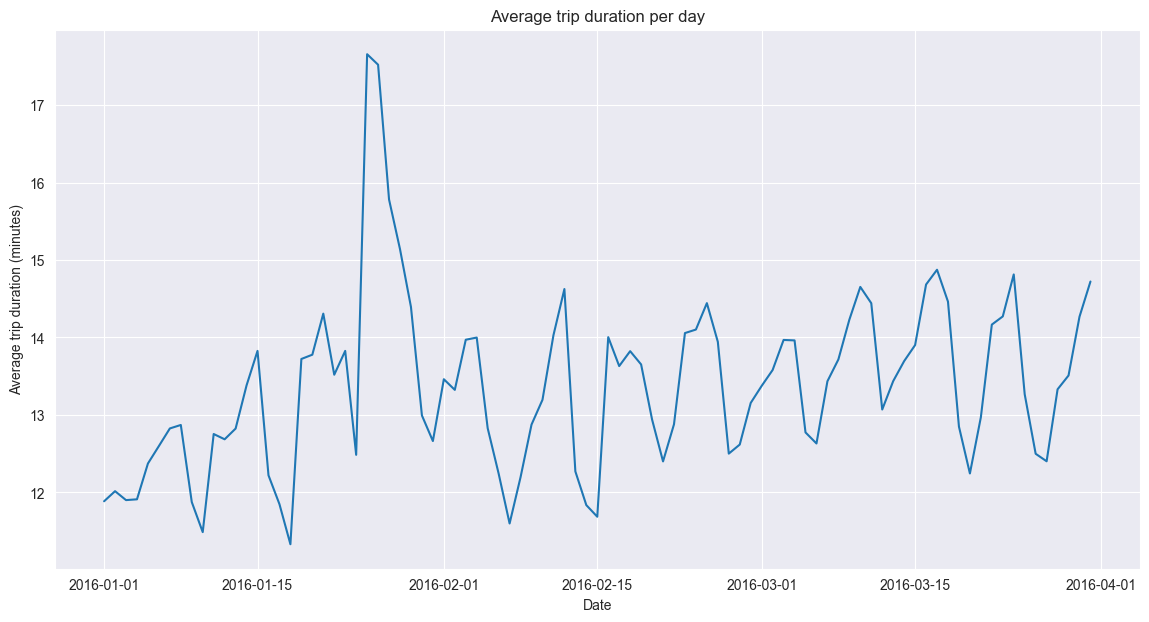

In [7]:
# Calculate the average duration of trips for each day
daily_avg_duration = df.groupby('pickup_date')['trip_duration'].mean()

# Visualize the trend of the average trip duration
plt.figure(figsize=(14, 7))
daily_avg_duration.plot()
plt.title('Average trip duration per day')
plt.xlabel('Date')
plt.ylabel('Average trip duration (minutes)')
plt.show()

## Stationarity analysis

In [44]:
daily_trips = df.groupby('pickup_date').size()

ts_daily_trips = daily_trips.copy()
ts_daily_trips.index = pd.to_datetime(ts_daily_trips.index)
ts_daily_trips = ts_daily_trips.asfreq('D', fill_value=0)

# Train and test
train_size = int(len(ts_daily_trips) * 0.8)
train_ts = ts_daily_trips[:train_size]
test_ts = ts_daily_trips[train_size:]

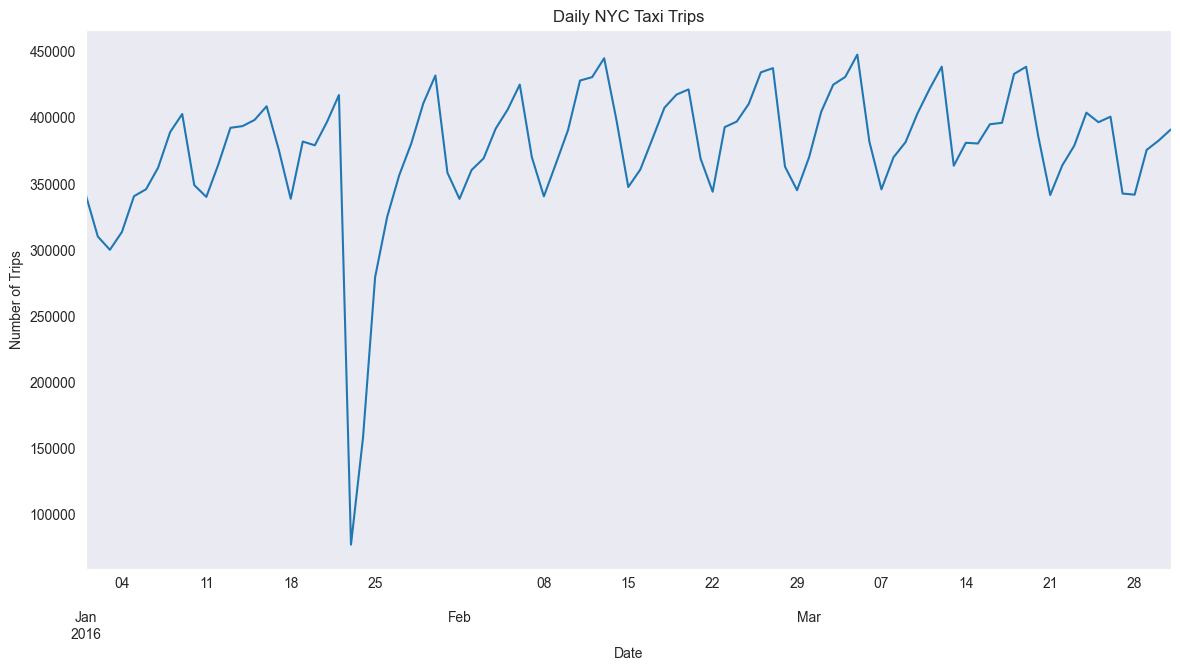

In [9]:
plt.figure(figsize=(14, 7))
ts_daily_trips.plot()
plt.title('Daily NYC Taxi Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid()
plt.show()

In [12]:
def test_stationarity_with_interpretation(timeseries):
    result = adfuller(timeseries)
    print('=== Augmented Dickey-Fuller Test ===')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpretazione del risultato
    if result[1] <= 0.05:
        print("\n✅ La serie è stazionaria")
    else:
        print("\n❌ La serie NON è stazionaria")

# Test sulla serie originale
print("\n[TEST SULLA SERIE ORIGINALE]")
test_stationarity_with_interpretation(train_ts)


[TEST SULLA SERIE ORIGINALE]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -5.6754
p-value: 8.730472056593261e-07
Critical Values:
   1%: -3.5061
   5%: -2.8946
   10%: -2.5844

✅ La serie è stazionaria


In [11]:
ts_daily_trips_diff = ts_daily_trips.diff().dropna()
print("\n[TEST SULLA SERIE DIFFERENZIATA]")
test_stationarity_with_interpretation(ts_daily_trips_diff)


[TEST SULLA SERIE DIFFERENZIATA]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -6.7295
p-value: 3.3244229103000903e-09
Critical Values:
   1%: -3.5107
   5%: -2.8966
   10%: -2.5855

✅ La serie è stazionaria


The $p$-value is less than $0.05$, which means that we can reject the null hypothesis that the time series is non-stationary. The time series is stationary.

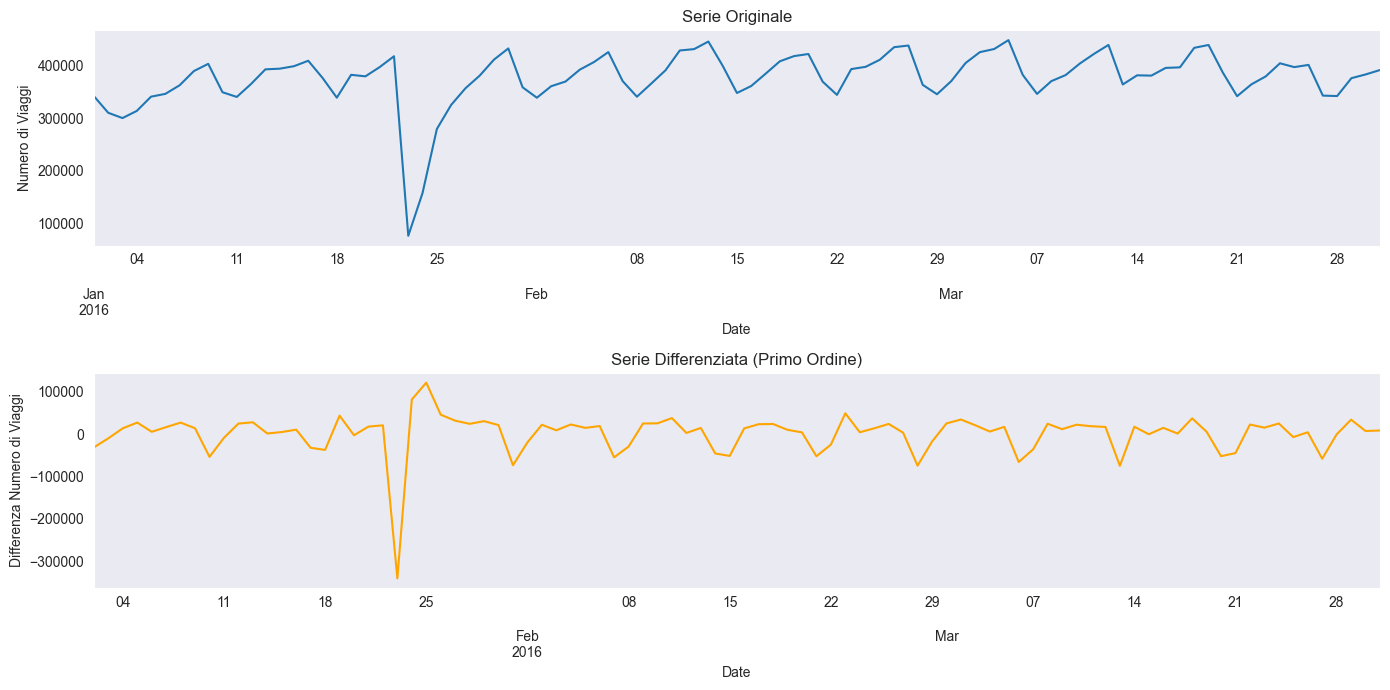

In [13]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
train_ts.plot(ax=plt.gca())
plt.title('Serie Originale')
plt.xlabel('Date')
plt.ylabel('Numero di Viaggi')
plt.grid()

plt.subplot(2, 1, 2)
ts_daily_trips_diff.plot(ax=plt.gca(), color='orange')
plt.title('Serie Differenziata (Primo Ordine)')
plt.xlabel('Date')
plt.ylabel('Differenza Numero di Viaggi')
plt.grid()
plt.tight_layout()
plt.show()

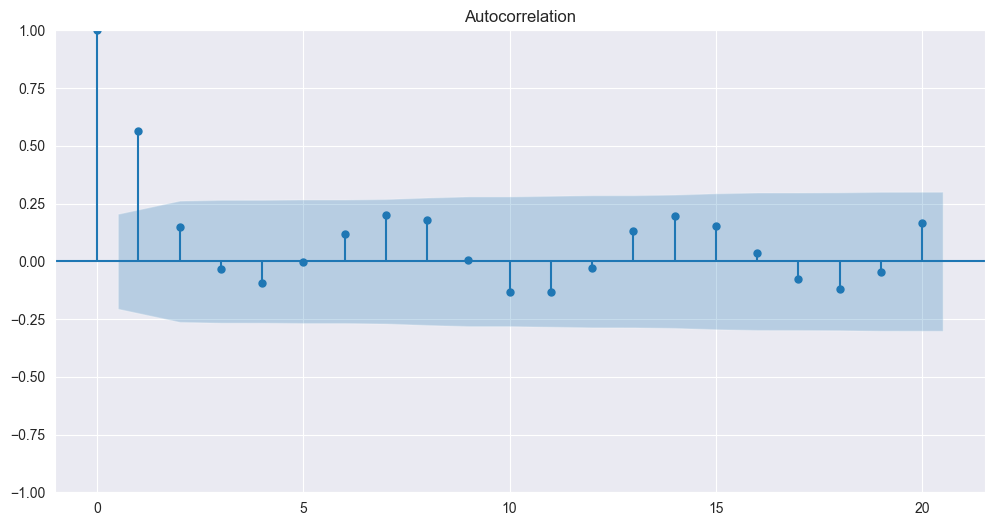

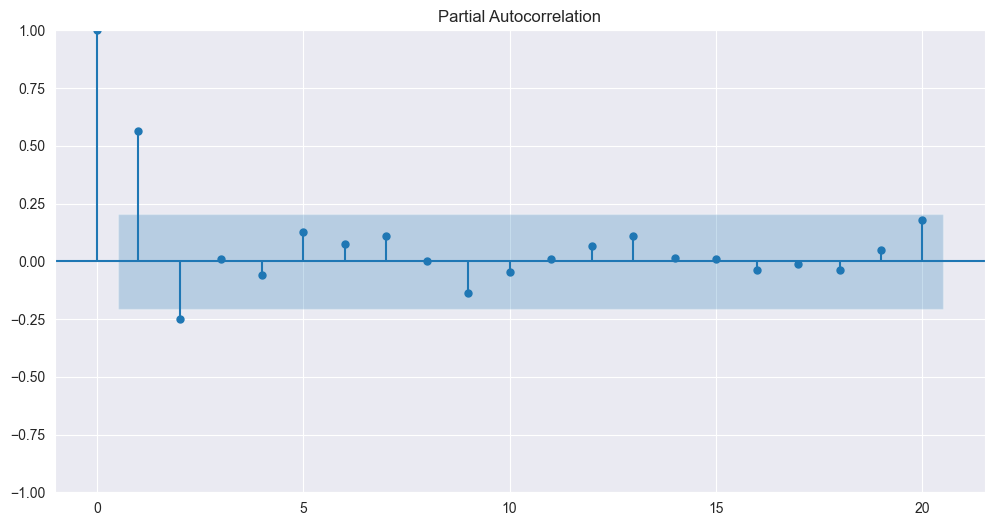

In [18]:
# Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train_ts, ax=plt.gca(), lags=20)
plt.show()

# Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(train_ts, ax=plt.gca(), lags=20)
plt.show()

### Automatic optimization of parameters with auto_arima

In [45]:
auto_arima_model = auto_arima(train_ts, d=0, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print("Best ARIMA model:", auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1766.480, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2055.822, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2008.704, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1765.933, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2000.712, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1779.607, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1766.724, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1999.978, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1780.168, Time=0.01 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1768.323, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1758.798, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1758.179, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1758.235, Time=0.00 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : 

In [23]:
auto_sarima_model = auto_arima(train_ts, d=0, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print("Best SARIMA model:", auto_sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2239.298, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2207.253, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2206.778, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2598.443, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=2205.643, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=2207.631, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=2204.063, Time=0.02 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=2204.559, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=2205.260, Time=0.03 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=2206.812, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=2205.229, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=2205.6

## ARIMA-SARIMA models
### p, d, q parameters

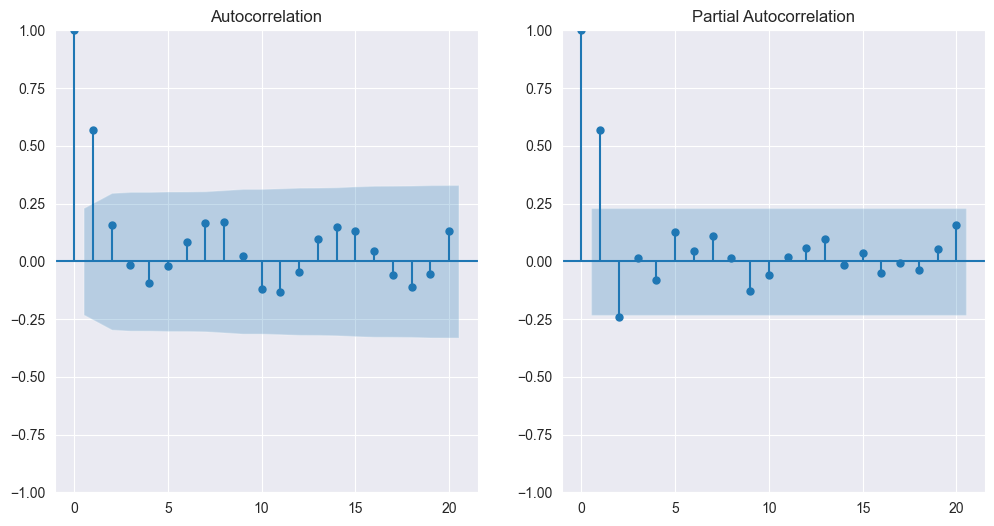

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_ts, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(train_ts, ax=plt.gca(), lags=20)
plt.show()

In [60]:
model = ARIMA(train_ts, order=(2, 2, 0))

arima_fit = model.fit()

print("\n=== ARIMA Model Summary ===")
print(arima_fit.summary())


=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -875.543
Date:                Mon, 25 Nov 2024   AIC                           1757.086
Time:                        11:13:14   BIC                           1763.831
Sample:                    01-01-2016   HQIC                          1759.765
                         - 03-12-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4749      0.043    -11.101      0.000      -0.559      -0.391
ar.L2         -0.3345      0.066     -5.075      0.000      -0.464      -0.205
sigma2      4.227e+09  

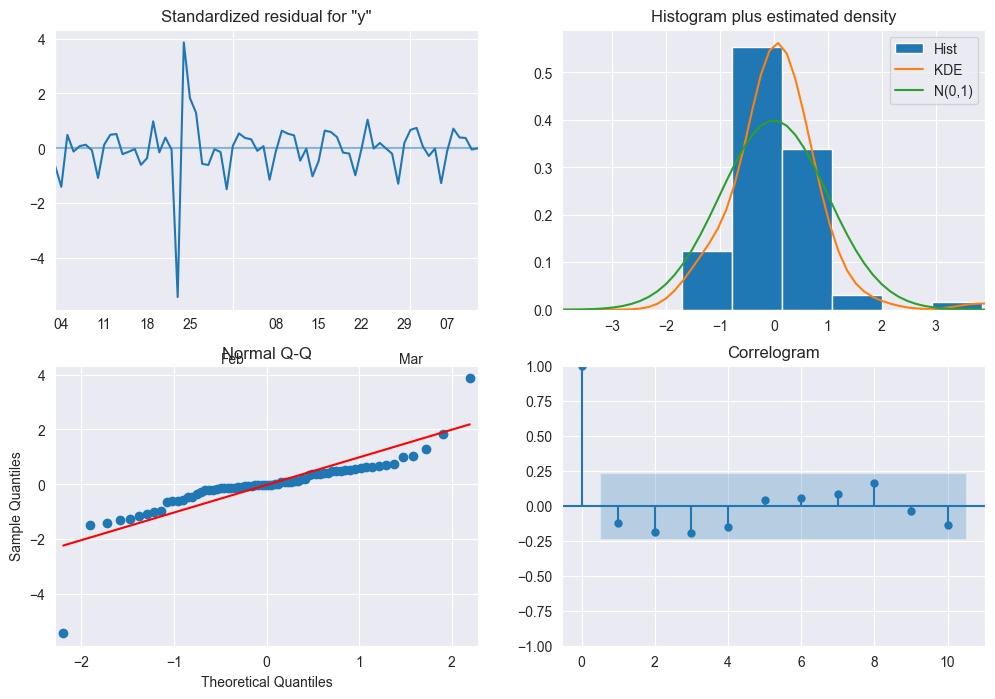

In [61]:
# Diagnostic plots
arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [70]:
model_sarima = sm.tsa.statespace.SARIMAX(train_ts, order=(2, 2, 0), seasonal_order=(2, 2, 0, 7))
sarima_fit = model_sarima.fit(method='bfgs')

print(sarima_fit.summary())

Optimization terminated successfully.
         Current function value: 10.211106
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   72
Model:             SARIMAX(2, 2, 0)x(2, 2, 0, 7)   Log Likelihood                -735.200
Date:                           Mon, 25 Nov 2024   AIC                           1480.399
Time:                                   11:19:04   BIC                           1490.526
Sample:                               01-01-2016   HQIC                          1484.325
                                    - 03-12-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

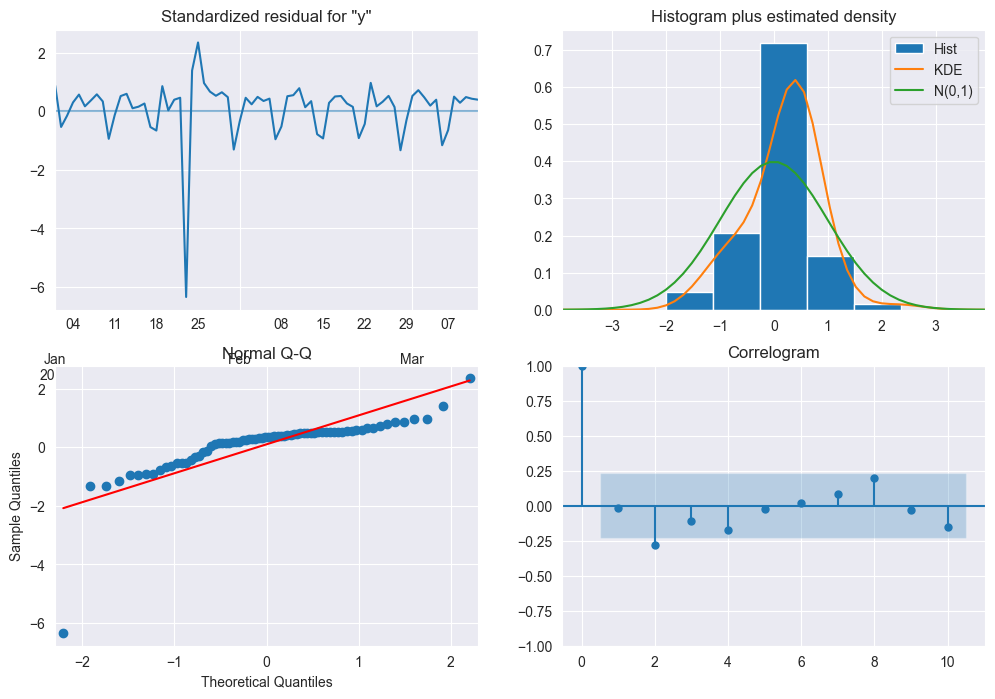

In [51]:
sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

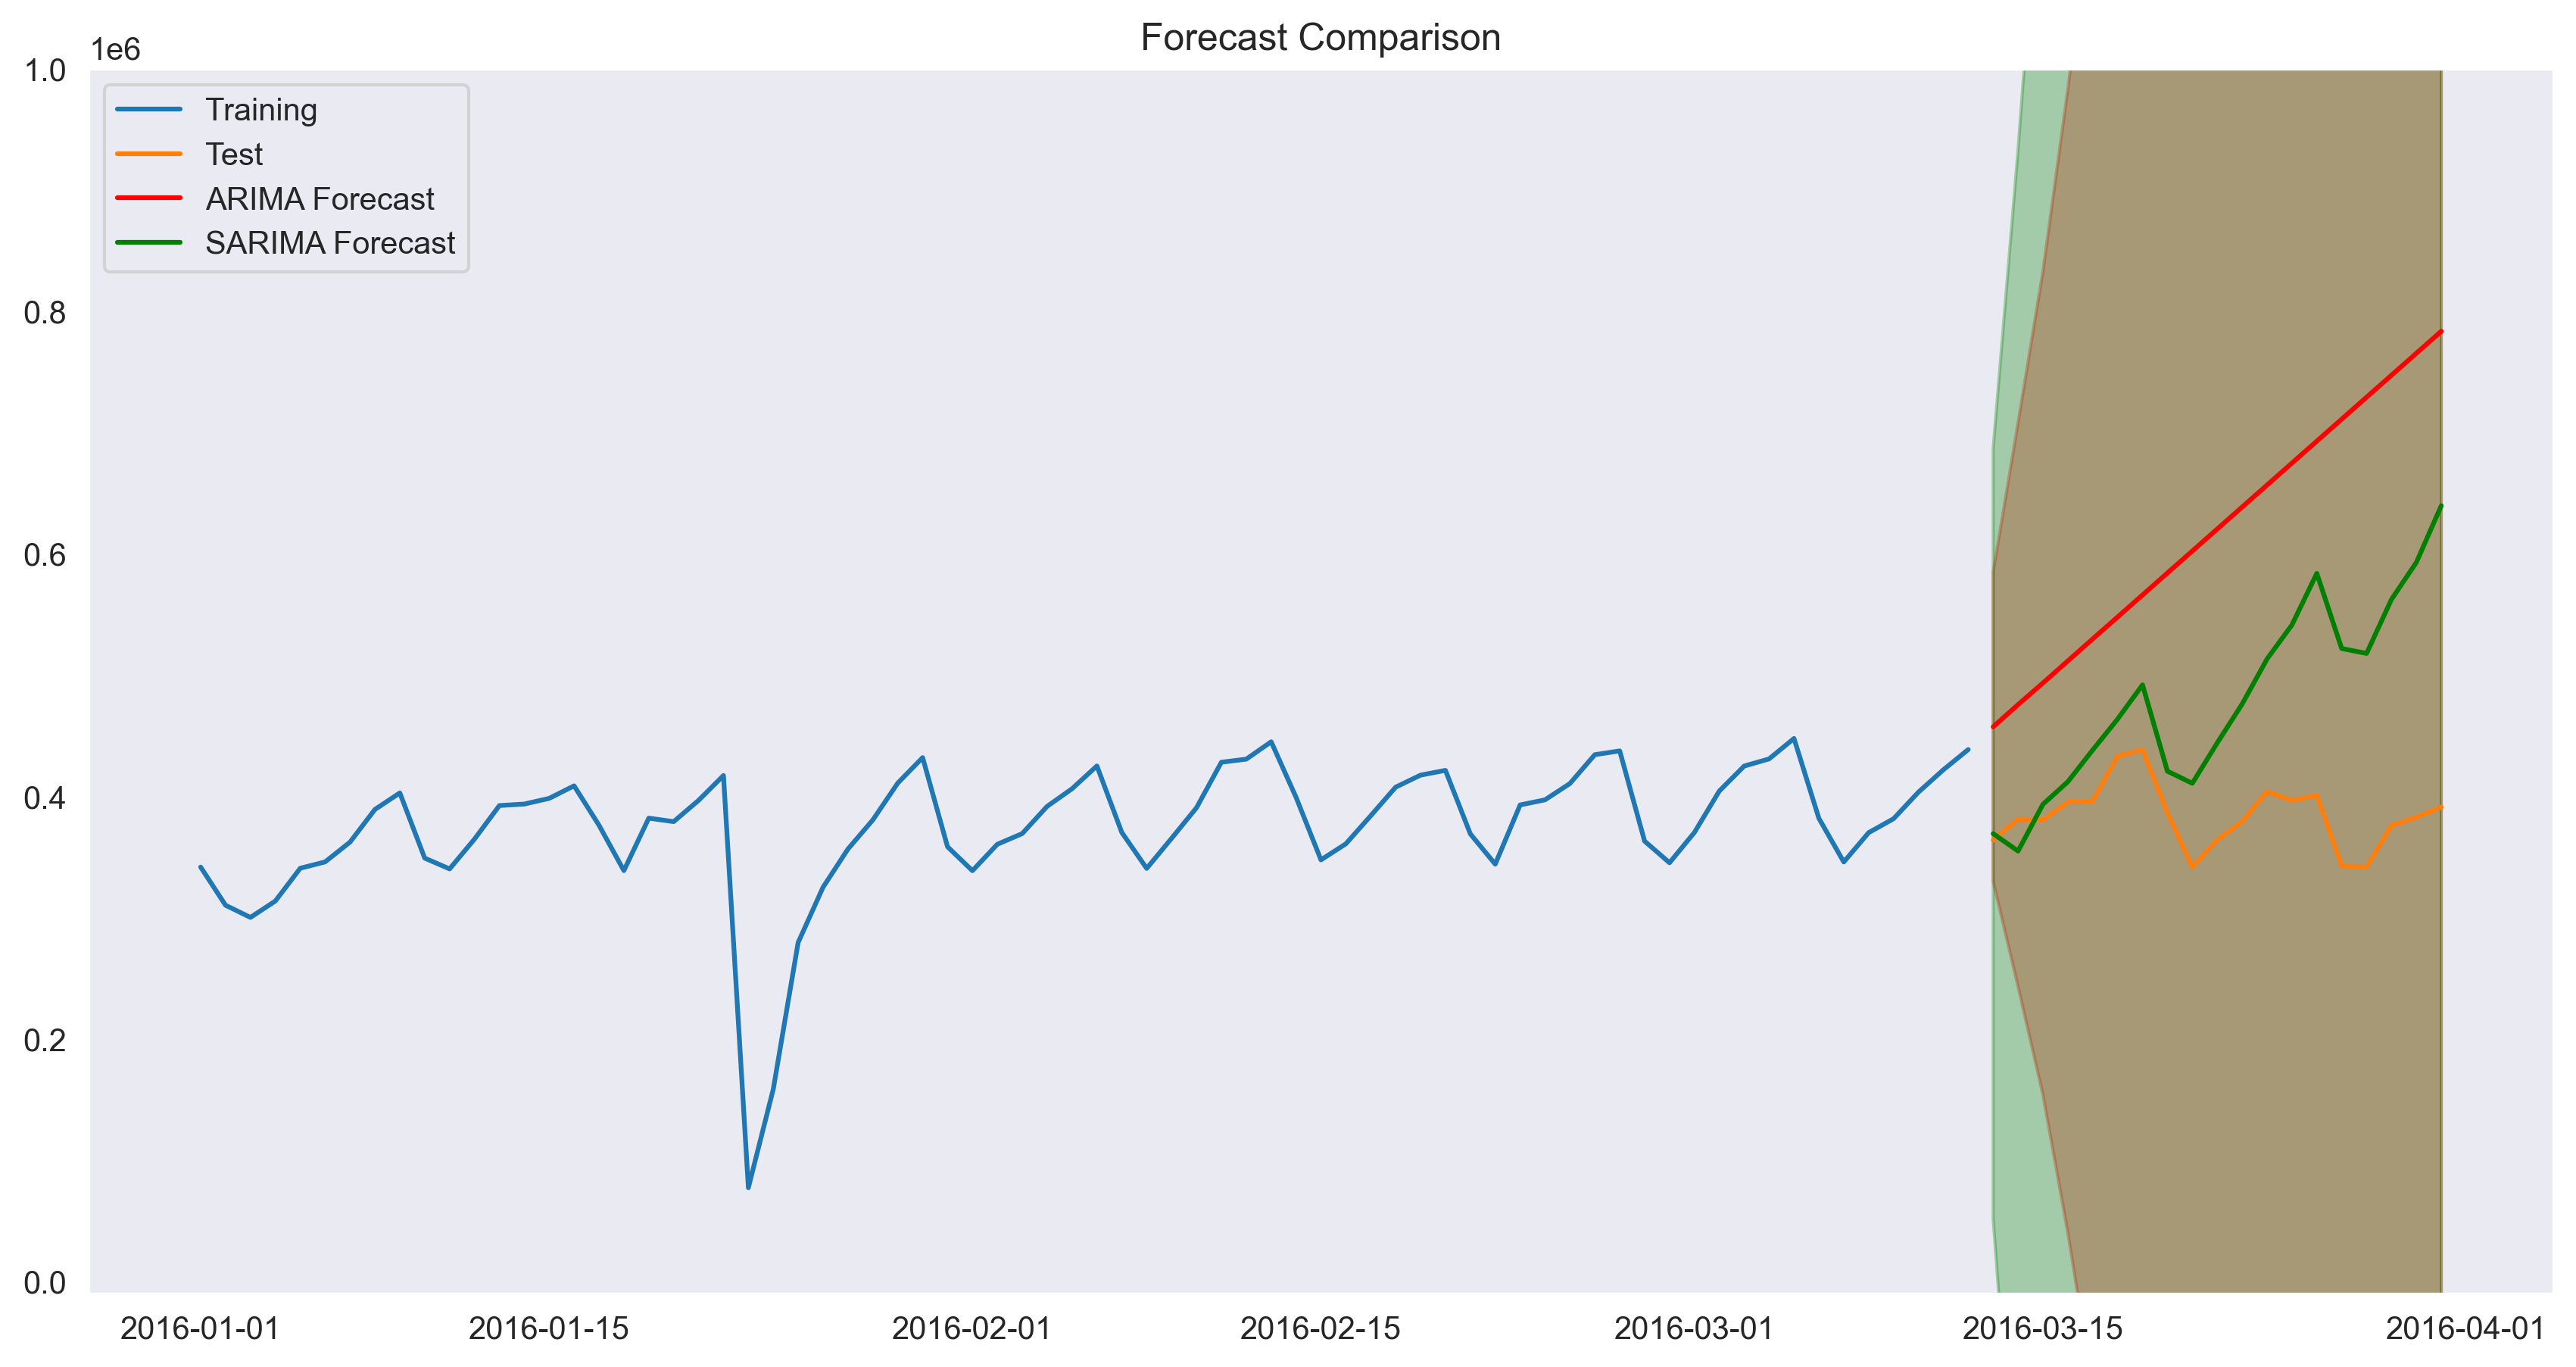

In [74]:
forecast_arima = arima_fit.get_forecast(steps=20)
forecast_sarima = sarima_fit.get_forecast(steps=20)

results = {
    'ARIMA': (forecast_arima.predicted_mean, forecast_arima.se_mean, forecast_arima.conf_int()),
    'SARIMA': (forecast_sarima.predicted_mean, forecast_sarima.se_mean, forecast_sarima.conf_int())
}

arima_fc_series = pd.Series(results['ARIMA'][0], index=test_ts.index)
sarima_fc_series = pd.Series(results['SARIMA'][0], index=test_ts.index)

arima_lower_series = pd.Series(results['ARIMA'][2].iloc[:, 0], index=test_ts.index)
arima_upper_series = pd.Series(results['ARIMA'][2].iloc[:, 1], index=test_ts.index)

sarima_lower_series = pd.Series(results['SARIMA'][2].iloc[:, 0], index=test_ts.index)
sarima_upper_series = pd.Series(results['SARIMA'][2].iloc[:, 1], index=test_ts.index)

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(train_ts, label='Training')
plt.plot(test_ts, label='Test')
plt.plot(arima_fc_series, label='ARIMA Forecast', color='red')
plt.plot(sarima_fc_series, label='SARIMA Forecast', color='green')
plt.ylim(-10000, 1000000)
plt.fill_between(arima_lower_series.index, arima_lower_series, arima_upper_series, color='red', alpha=0.3)
plt.fill_between(sarima_lower_series.index, sarima_lower_series, sarima_upper_series, color='green', alpha=0.3)
plt.title('Forecast Comparison')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()

# plt.figure(figsize=(14, 7))
# plt.plot(ts_daily_trips, label='Observed')
# plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean.values, label='ARIMA Forecast', color='red')
# plt.fill_between(forecast_arima_ci.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color='red', alpha=0.3)
# plt.plot(forecast_sarima.predicted_mean.index, forecast_sarima.predicted_mean.values, label='SARIMA Forecast', color='green')
# plt.fill_between(forecast_sarima_ci.index, forecast_sarima_ci.iloc[:, 0], forecast_sarima_ci.iloc[:, 1], color='green', alpha=0.3)
# plt.title('Forecast Comparison')
# plt.xlabel('Date')
# plt.ylabel('Number of Trips')
# plt.legend()
# plt.grid()
# plt.show()

## Hour based analysis

Escludiamo il file CSV relativo a gennaio 2015 in modo tale da ottenere una sottosezione dell'intero dataset relativa al periodo gennaio2016-febbario2016. In questo modo, in quell'intervallo i dati potranno essere aggragati su base oraria con intervalli uniformi tra ogni osservazione

In [75]:
# Specificare i file rilevanti per gennaio, febbraio e marzo 2016
hour_dfs = [pd.read_csv(f, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) 
            for f in file_paths]
hour_df = pd.concat(hour_dfs, ignore_index=True)

In [76]:
# Rimuovere righe con valori nulli
hour_df.dropna(subset=columns, inplace=True)

# Filtrare viaggi con valori negativi o anomali
hour_df = hour_df[(hour_df['trip_distance'] > 0) & 
                  (hour_df['fare_amount'] > 0) & 
                  (hour_df['total_amount'] > 0)]

# Calcolare la durata del viaggio
hour_df['trip_duration'] = (hour_df['tpep_dropoff_datetime'] - hour_df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filtrare viaggi con durata negativa o eccessiva (>4 ore)
hour_df = hour_df[(hour_df['trip_duration'] > 0) & (hour_df['trip_duration'] < 240)]

In [77]:
# Creare un indice temporale arrotondando al più vicino inizio dell'ora
hour_df['pickup_hour'] = hour_df['tpep_pickup_datetime'].dt.floor('H')

# Aggregare il numero di viaggi per ogni ora
hourly_trips = hour_df.groupby('pickup_hour').size()

# Trasformare in una serie temporale con frequenza fissa
hourly_ts = hourly_trips.asfreq('H', fill_value=0)

# Train and test
train_size = int(len(hourly_ts) * 0.8)
train_hourly_ts = hourly_ts[:train_size]
test_hourly_ts = hourly_ts[train_size:]

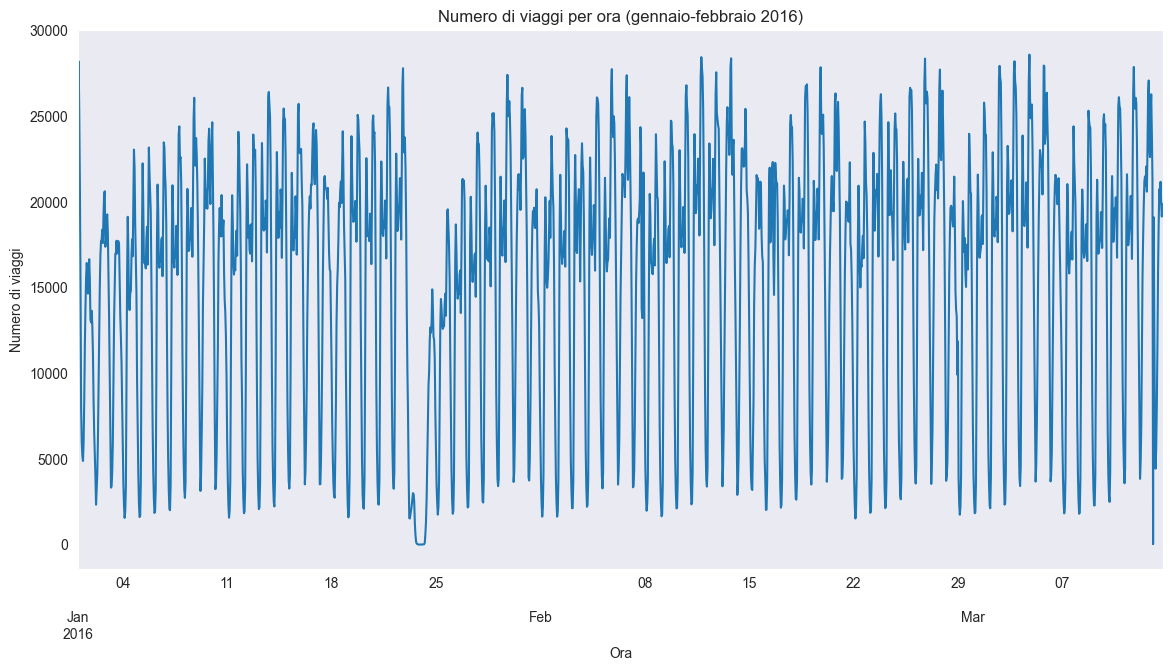

In [78]:
plt.figure(figsize=(14, 7))
train_hourly_ts.plot()
plt.title('Numero di viaggi per ora (gennaio-febbraio 2016)')
plt.xlabel('Ora')
plt.ylabel('Numero di viaggi')
plt.grid()
plt.show()


In [79]:
print("\n[TEST SULLA SERIE ORIGINALE]")
test_stationarity_with_interpretation(train_hourly_ts)


[TEST SULLA SERIE ORIGINALE]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -4.3054
p-value: 0.00043472185795410056
Critical Values:
   1%: -3.4342
   5%: -2.8632
   10%: -2.5677

✅ La serie è stazionaria


In [80]:
auto_arima_model = auto_arima(train_hourly_ts, seasonal=True, d=0, m=24, trace=True, error_action='ignore', suppress_warnings=True)
print("Best ARIMA model:", auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=31163.618, Time=9.52 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=36105.607, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=31542.272, Time=4.87 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=33241.011, Time=3.58 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=39048.660, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=31421.405, Time=5.34 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=31204.886, Time=7.18 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=27.89 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=31198.053, Time=36.89 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=32018.209, Time=0.16 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=31211.568, Time=20.79 sec


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105726e50>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



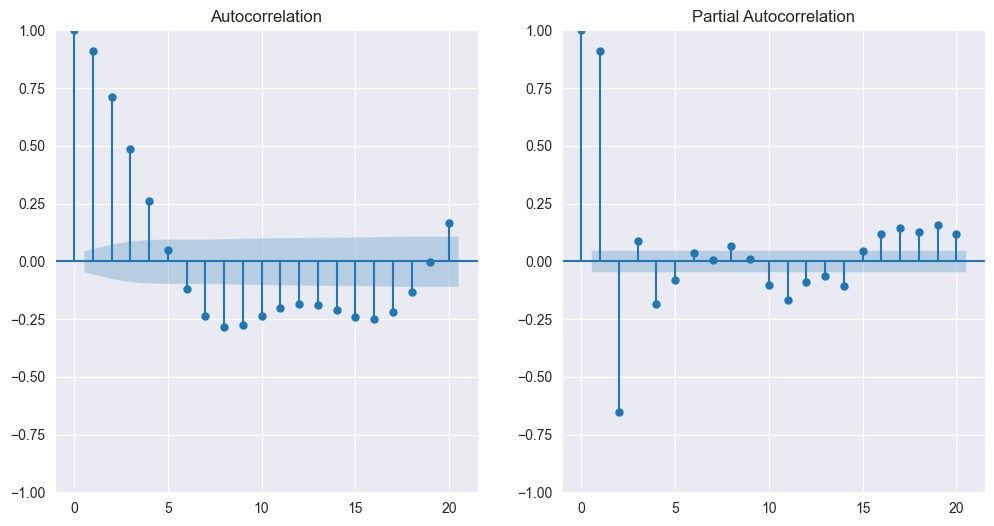

In [81]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_hourly_ts, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(train_hourly_ts, ax=plt.gca(), lags=20)
plt.show()

In [93]:
hourly_arima_model = ARIMA(train_hourly_ts, order=(3,2,0))

hourly_arima_fit = hourly_arima_model.fit()

print("\n=== ARIMA Model Summary ===")
print(hourly_arima_fit.summary())


=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1747
Model:                 ARIMA(3, 2, 0)   Log Likelihood              -16301.743
Date:                Mon, 25 Nov 2024   AIC                          32611.487
Time:                        11:39:18   BIC                          32633.345
Sample:                    01-01-2016   HQIC                         32619.568
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0447      0.013     -3.350      0.001      -0.071      -0.019
ar.L2         -0.2792      0.017    -16.109      0.000      -0.313      -0.245
ar.L3         -0.1219  

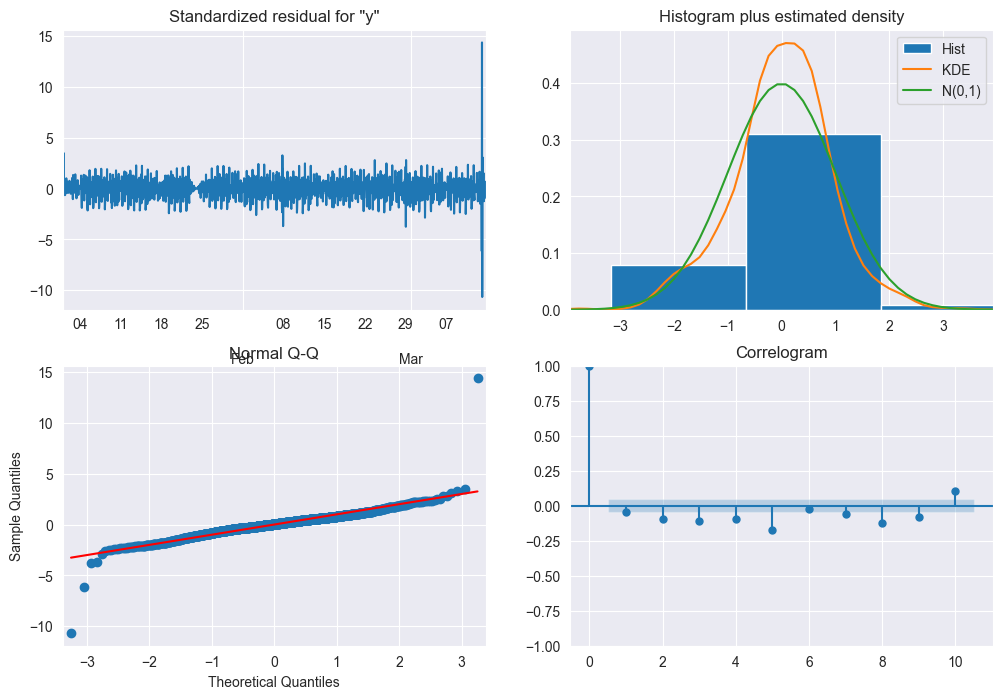

In [83]:
hourly_arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [92]:
hourly_model_sarima = sm.tsa.statespace.SARIMAX(train_hourly_ts, order=(3, 2, 0), seasonal_order=(3, 2, 0, 24))
hourly_sarima_fit = hourly_model_sarima.fit()

print(hourly_sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03886D+00    |proj g|=  7.44727D-02

At iterate    5    f=  9.03331D+00    |proj g|=  1.04703D-04

At iterate   10    f=  9.03331D+00    |proj g|=  8.20795D-04

At iterate   15    f=  9.03310D+00    |proj g|=  1.05651D-02

At iterate   20    f=  9.01644D+00    |proj g|=  8.21938D-02

At iterate   25    f=  8.99729D+00    |proj g|=  8.14667D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   

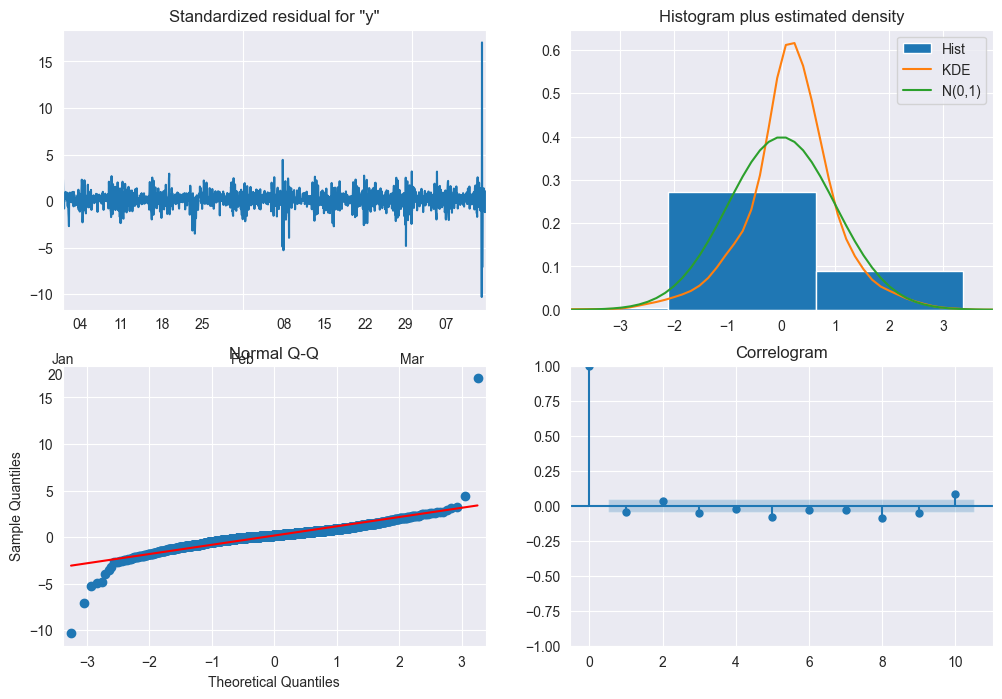

In [87]:
hourly_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

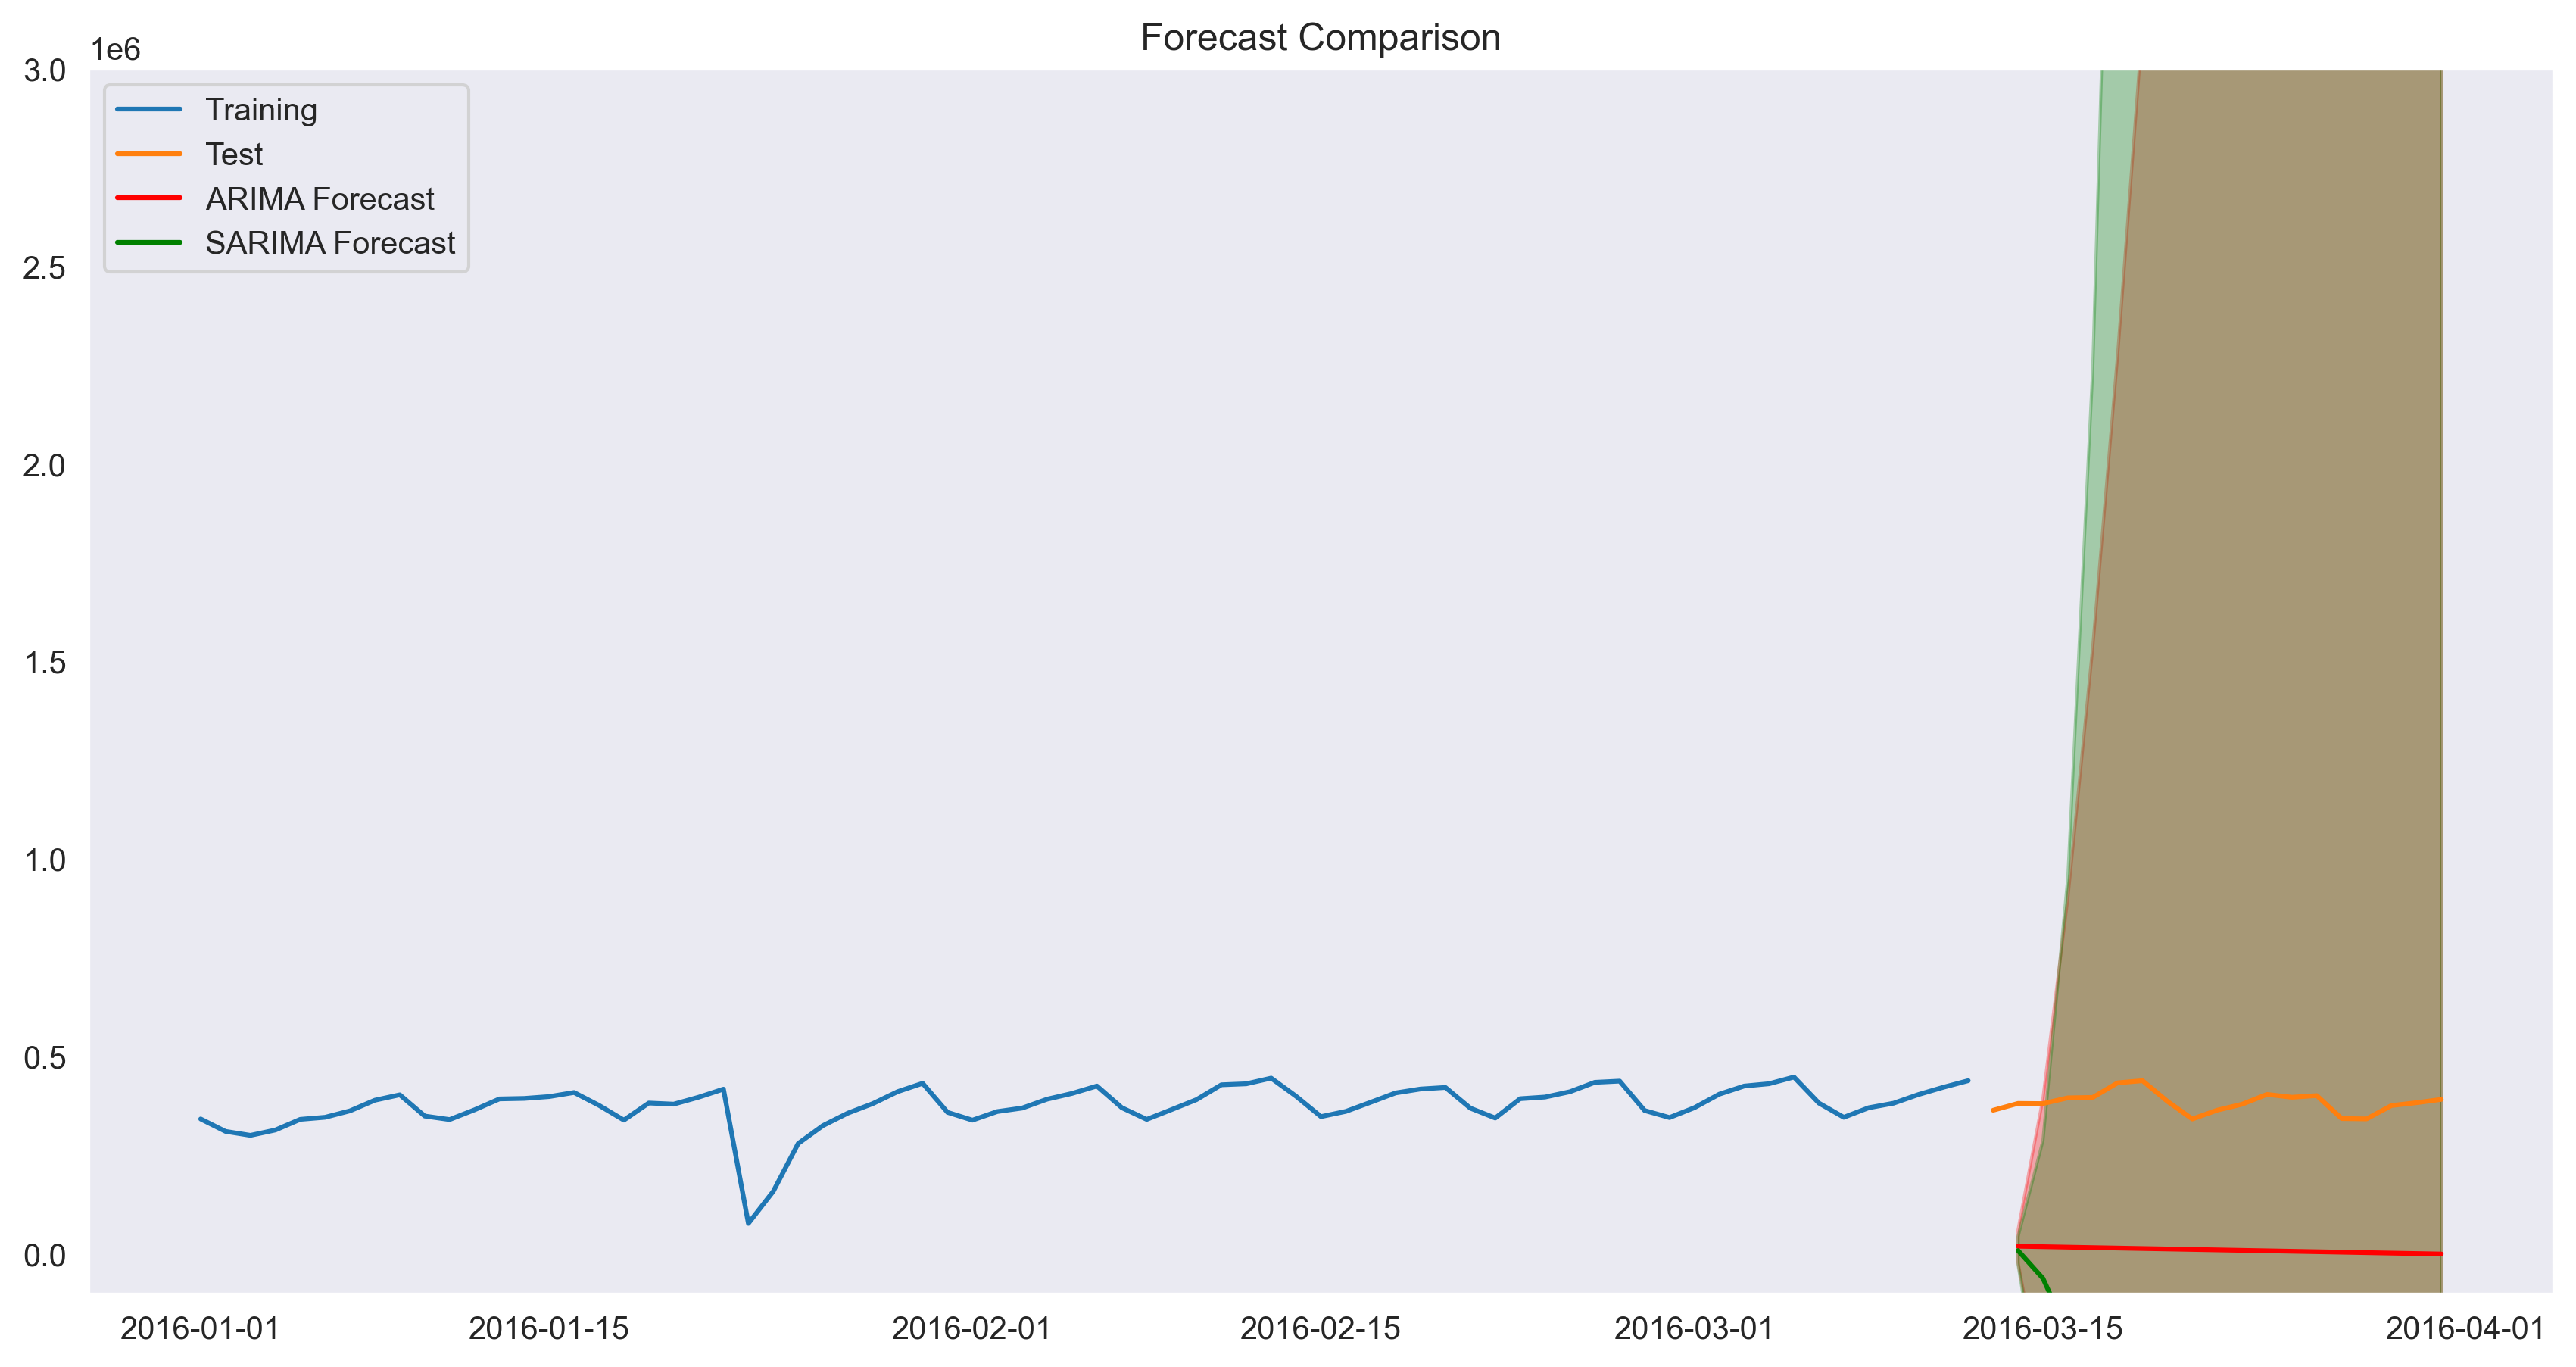

In [101]:
hourly_forecast_arima = hourly_arima_fit.get_forecast(steps=24*20)
hourly_forecast_sarima = hourly_sarima_fit.get_forecast(steps=24*20)

results = {
    'ARIMA': (hourly_forecast_arima.predicted_mean, hourly_forecast_arima.se_mean, hourly_forecast_arima.conf_int()),
    'SARIMA': (hourly_forecast_sarima.predicted_mean, hourly_forecast_sarima.se_mean, hourly_forecast_sarima.conf_int())
}

arima_fc_series = pd.Series(results['ARIMA'][0], index=test_ts.index)
sarima_fc_series = pd.Series(results['SARIMA'][0], index=test_ts.index)

arima_lower_series = pd.Series(results['ARIMA'][2].iloc[:, 0], index=test_ts.index)
arima_upper_series = pd.Series(results['ARIMA'][2].iloc[:, 1], index=test_ts.index)

sarima_lower_series = pd.Series(results['SARIMA'][2].iloc[:, 0], index=test_ts.index)
sarima_upper_series = pd.Series(results['SARIMA'][2].iloc[:, 1], index=test_ts.index)

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(train_ts, label='Training')
plt.plot(test_ts, label='Test')
plt.plot(arima_fc_series, label='ARIMA Forecast', color='red')
plt.plot(sarima_fc_series, label='SARIMA Forecast', color='green')
plt.ylim(-100000, 3000000)
plt.fill_between(arima_lower_series.index, arima_lower_series, arima_upper_series, color='red', alpha=0.3)
plt.fill_between(sarima_lower_series.index, sarima_lower_series, sarima_upper_series, color='green', alpha=0.3)
plt.title('Forecast Comparison')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()